# Notebook configuration

In [52]:
run_number    = 4452
save_plots    = False
outputfolder  = "plots/{}/".format(run_number)
corr_filename = "merged_corrections.h5"
inputfilename = "/home/brais/Documents/Next/Cs/data/{0}/dst_{0}.root.h5".format(run_number)

Zrange        =    0, 600
XYrange       = -198, 198
Rrange        =    0, max(XYrange)
Prange        = -3.2, 3.2  
Erange_raw    =    0, 3e5
Erange_zcorr  =  5e3, 2e5
Erange_xycorr =  5e3, 2e5
Erange_XR     =  6e3, 12e3
Qrange        =    0, 40e2

S1Erange      =    0, 250
S1Wrange      =    0, 300
S1Hrange      =    0, 400
S2Wrange      =    0, 40
S2Hrange      =    0, 50e3
NSirange      =    0, 30

Zrange_LT     =   50, 350
nX, nY        =   50,  50

# Cs analysis

In [53]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .dst_io         as dstio
import invisible_cities.reco.corrections    as corrf

from icaro.core.hst_functions import hist
from icaro.core.hst_functions import hist2d
from icaro.core.hst_functions import pdf
from icaro.core.hst_functions import labels
from icaro.core.hst_functions import hist2d_profile
from icaro.core.hst_functions import covariance
from icaro.core.hst_functions import resolution
from icaro.core.hst_functions import gausstext
from icaro.core.hst_functions import shift_to_bin_centers
from icaro.core.hst_functions import save_to_folder
from icaro.core.hst_functions import scatter

from copy import copy

pi   = np.pi
save = functools.partial(save_to_folder, outputfolder) if save_plots else lambda *x: None

Running on  Mon Jul 10 20:51:25 2017


#### General plotting options

In [54]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

### Useful functions

In [55]:
two_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:-1])+args[-1]
one_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) +args[-1]

def plot_map(xy_map, run=""):
    x , y  = xy_map._xs
    x0, y0 = np.min(x) - np.diff(x)[0]/2, np.min(y) - np.diff(y)[0]/2
    x1, y1 = np.max(x) + np.diff(x)[0]/2, np.max(y) + np.diff(y)[0]/2
    f      = xy_map._fs
    u      = xy_map._us
    x, y   = np.repeat(x, y.size), np.tile(y, x.size)

    plt.figure()

    #plt.subplot(1, 2, 1)
    hist2d(x, y, f.shape, ((x0, x1), (y0, y1)), weights=f.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction factor")
    labels("x (mm)", "y (mm)", str(run))
    plt.savefig("merged_map.pdf")
    """
    plt.subplot(1, 2, 2)
    hist2d(x, y, u.shape, ((x0, x1), (y0, y1)), weights=u.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction uncertainty")
    labels("x (mm)", "y (mm)", str(run))
    """
    
def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()

# Read data

In [78]:
full = dstf.load_dst(inputfilename, "DST", "Events")
full = full[(full.R<max(Rrange))] # soft radial cut to reduce badly reconstructed events
print(len(full))
full.head()

3757


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.499707e+09,0,1,225.0,49.925045,256.638949,136075.0,43.366687,7408.800781,...,662812.5,46,526.7375,526.7375,156.236453,-19.082455,157.397488,-0.121536,13.405103,15.898536
1,2,1.499707e+09,0,1,200.0,53.646015,278.180765,466850.0,36.867000,9599.762695,...,674237.5,36,207.3875,207.3875,25.219295,-63.289933,68.129498,-1.191607,11.817029,13.409226
2,4,1.499707e+09,0,1,200.0,41.780174,216.826807,396800.0,52.850813,8510.296875,...,660362.5,49,263.5625,263.5625,-88.965578,-93.595981,129.132032,-2.330836,15.866580,16.133229
3,5,1.499707e+09,0,1,175.0,27.139069,133.668575,536700.0,24.748000,11986.133789,...,669012.5,51,132.3125,132.3125,-62.448637,80.145838,101.603089,2.232717,37.769792,44.605178
4,7,1.499707e+09,0,1,200.0,39.639145,202.842133,137925.0,41.932063,11303.938477,...,657787.5,37,519.8625,519.8625,70.849812,37.603790,80.210603,0.487947,13.066028,13.746847


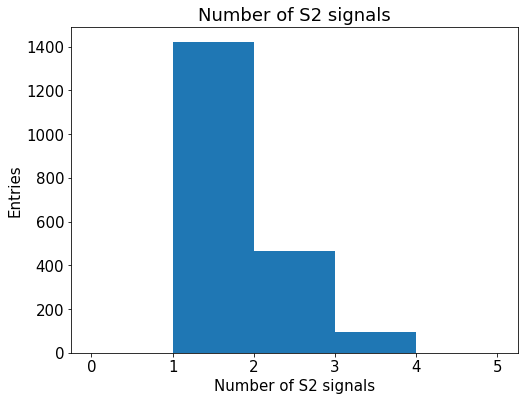

In [57]:
hist(full.nS2, 5, (0, 5))
labels("Number of S2 signals", "Entries", "Number of S2 signals")
save("NS2")

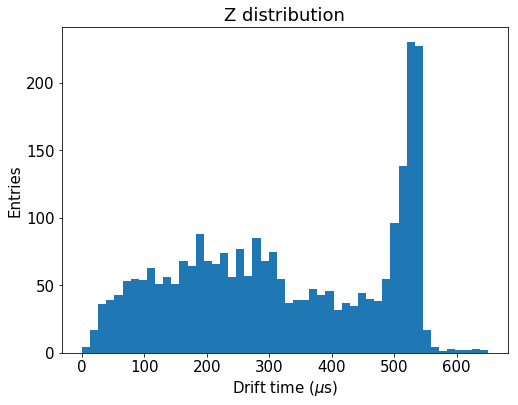

In [79]:
hist(full[full.nS2==1].Z, 50, [0,650])
labels("Drift time ($\mu$s)", "Entries", "Z distribution")

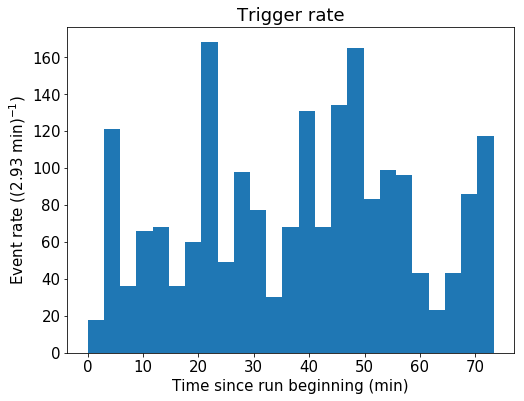

In [59]:
T       = full.time.values / 60
T      -= np.min(T)
 
y, x, _ = hist(T, 25, (np.min(T), np.max(T)))
labels("Time since run beginning (min)",
       "Event rate (({:.2f} min)$^{{-1}}$)".format(np.diff(x)[0]), "Trigger rate")

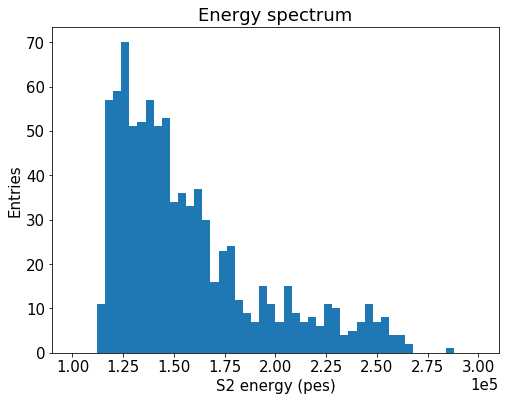

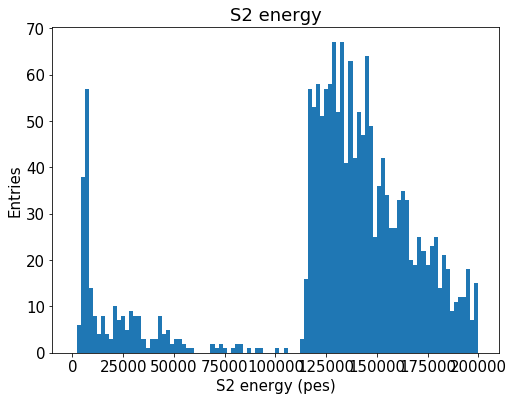

In [68]:
hist(full.S2e[(full.nS2==1)&(full.Z<400)], 50, (100e3,300e3))
labels("S2 energy (pes)", "Entries", "Energy spectrum")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
hist(full.S2e, 100, (0, 200e3))
labels("S2 energy (pes)", "Entries", "S2 energy")

# S1 energy

NameError: name 'sel_E' is not defined

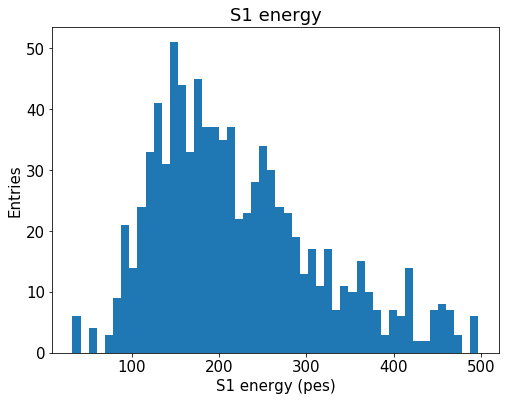

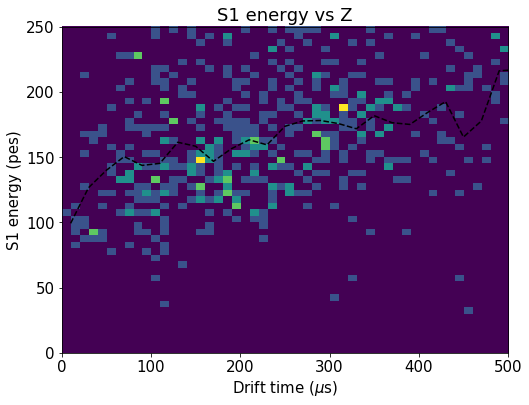

In [10]:
sel_PP = fitf.in_range(full.S2e, 0, 1000e5)

hist(full[sel_PP].S1e, 50)
labels("S1 energy (pes)", "Entries", "S1 energy")
save("S1energy")

hist2d(full[sel_PP].Z, full[sel_PP].S1e, (50, 50), range=([0,500], S1Erange))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S1e, 30, xrange=Zrange, yrange=S1Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)", "S1 energy vs Z")
save("S1energyvsZ")

sel_Z   = fitf.in_range(full.Z, 0, 500)
sel_nS2 = full.nS2=1

sel = sel_Z & sel_nS2 & sel_E
profile_and_scatter(full[sel_PP].X.values, full[sel_PP].Y.values, full[sel_PP].S1e.values, [50,50]);
labels("X (mm)", "Y (mm)", "S1 energy vs XY")
save("S1energyvsXY")


# S1 width

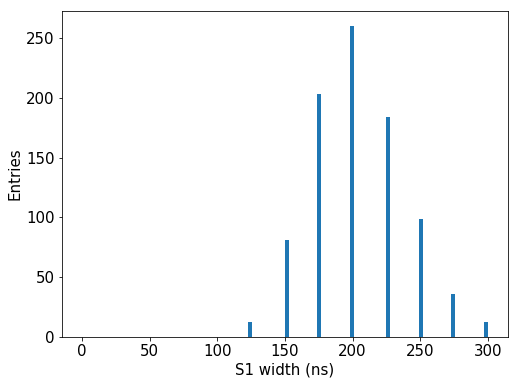

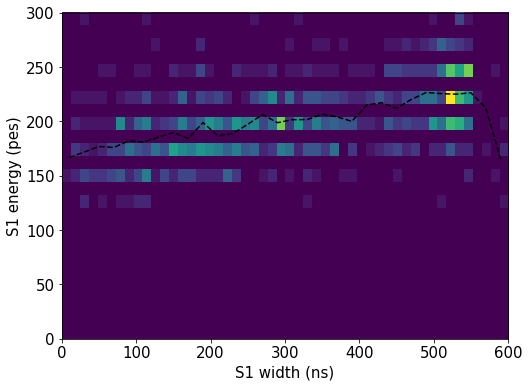

In [11]:
nb = max(S1Wrange)//25
hist(full[sel_PP].S1w, 100, S1Wrange)
labels("S1 width (ns)", "Entries")
save("S1width")

hist2d(full[sel_PP].Z, full[sel_PP].S1w, (50, 25), range=(Zrange, S1Wrange))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S1w, 30, xrange=Zrange, yrange=S1Wrange)
plt.plot(x, y, profOpt)

labels("S1 width (ns)", "S1 energy (pes)")
save("S1widthvsZ")

# S1 height

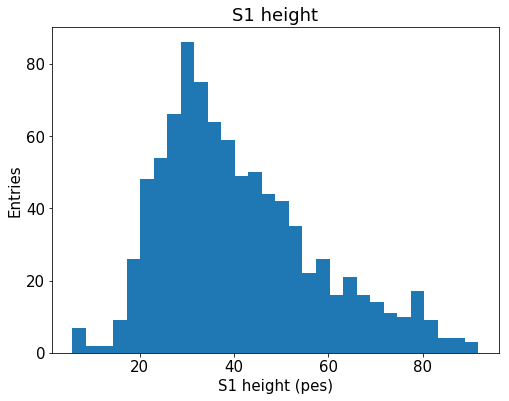

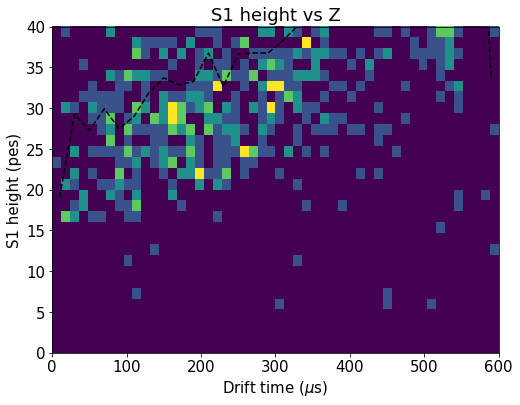

In [12]:
hist(full[sel_PP].S1h, 30)
labels("S1 height (pes)", "Entries", "S1 height")
save("S1height")

hist2d(full[sel_PP].Z, full[sel_PP].S1h, (50, 30), range=(Zrange, [0,40]))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S1h, 30, xrange=Zrange, yrange=S1Hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 height (pes)", "S1 height vs Z")
save("S1heightvsZ")

# S1 peak to area ratio

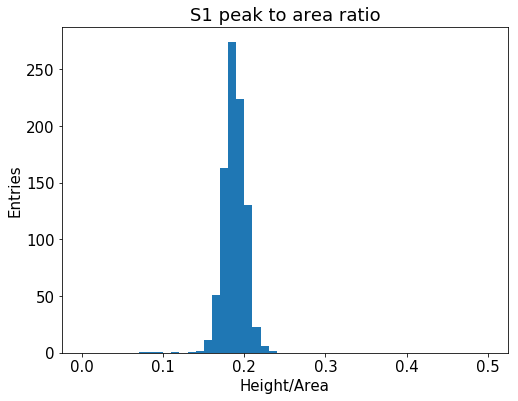

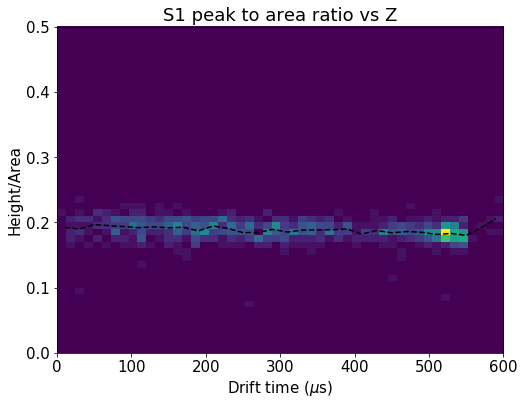

In [13]:
S1r    = full[sel_PP].S1h/full[sel_PP].S1e
_range = 0, 0.5

hist(S1r, 50, range=_range)
labels("Height/Area", "Entries", "S1 peak to area ratio")
save("S1Peak2Area")

hist2d(full[sel_PP].Z, S1r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full[sel_PP].Z, S1r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area", "S1 peak to area ratio vs Z")
save("S1ratiovsZ")

# S2 energy

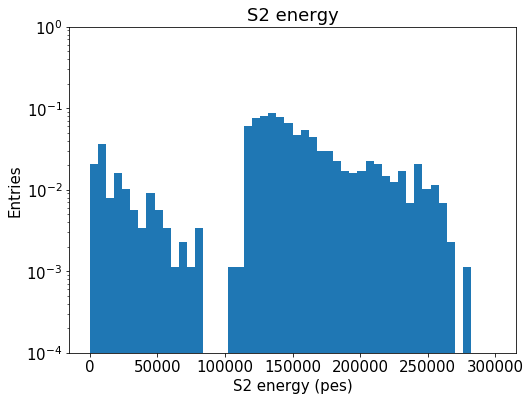

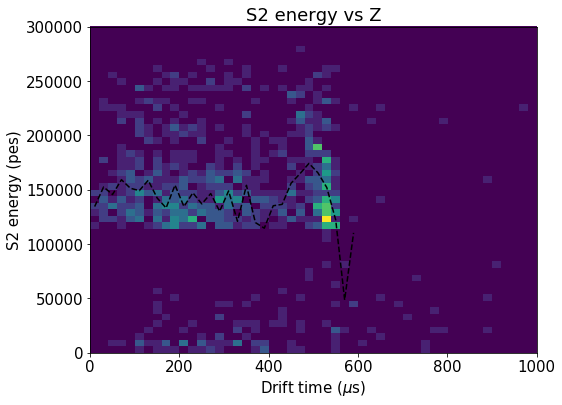

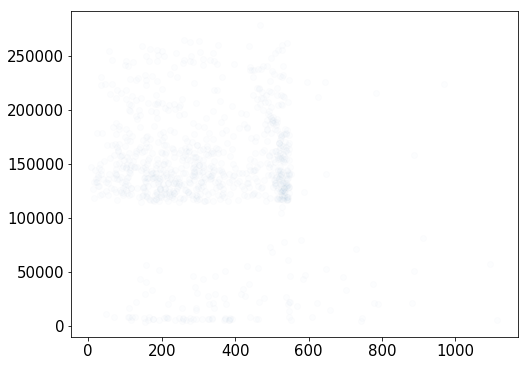

In [40]:
Erange_raw = 0e5,3e5

data = full
data = data
data = data[data.S2e<3e5]

pdf(data.S2e, 50, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("S2energy")

hist2d(data.Z, data.S2e, (50, 50), range=([0,1000], Erange_raw))
x, y, _ = fitf.profileX(data.Z, data.S2e, 30, xrange=Zrange, yrange=Erange_raw)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 energy vs Z")
save("S2energyvsZ")

scatter(data.Z, data.S2e, alpha=0.01,)


# S2 width

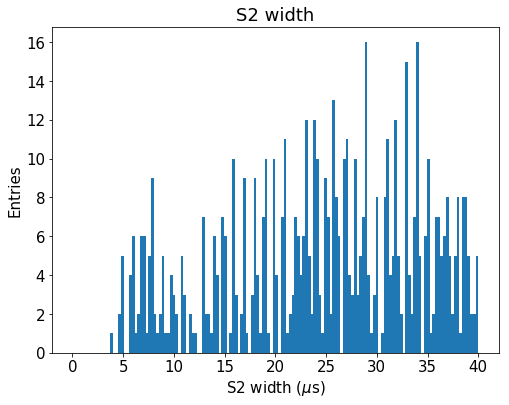

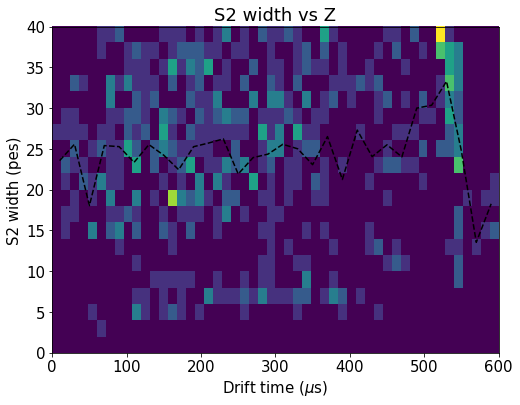

In [15]:
hist(full.S2w, 150, range=S2Wrange)
labels("S2 width ($\mu$s)", "Entries", "S2 width")
save("S2width")

hist2d(full[sel_PP].Z, full[sel_PP].S2w, (50, 20), range=(Zrange, S2Wrange))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S2w, 30, xrange=Zrange, yrange=S2Wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 width (pes)", "S2 width vs Z")
save("S2widthvsZ")

# S2 height

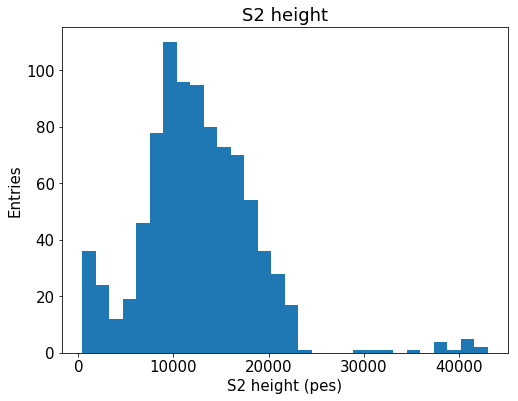

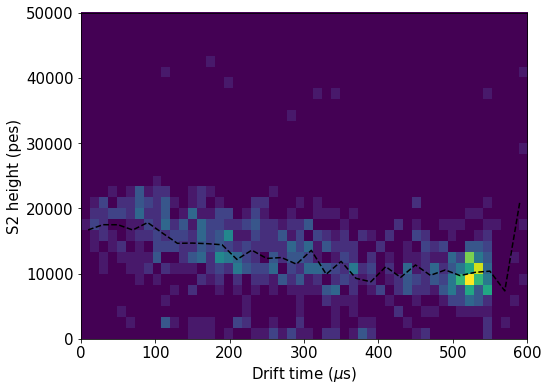

In [16]:
hist(full.S2h, 30)
labels("S2 height (pes)", "Entries", "S2 height")
save("S2height")

hist2d(full[sel_PP].Z, full[sel_PP].S2h, (50, 30), range=(Zrange, S2Hrange))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S2h, 30, xrange=Zrange, yrange=S2Hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

# S2 peak to area ratio

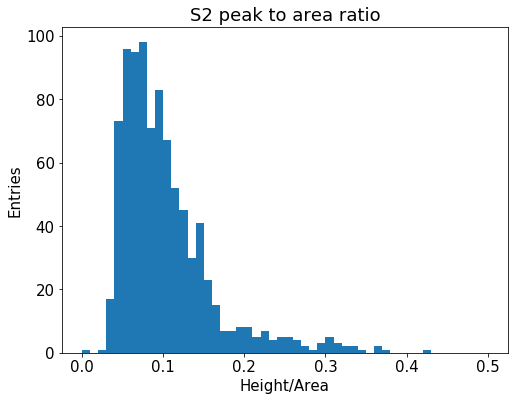

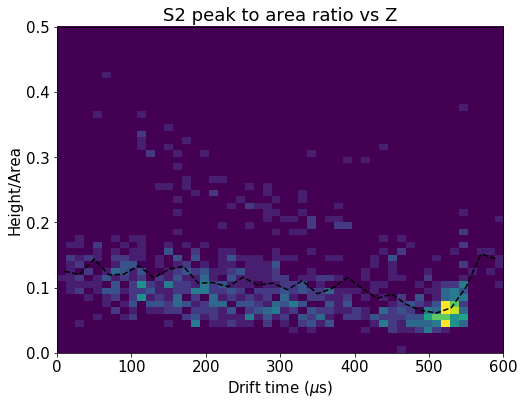

In [17]:
_range = 0, 0.5

S2r = full[sel_PP].S2h/full[sel_PP].S2e

hist(S2r, 50, range=_range)
labels("Height/Area", "Entries", "S2 peak to area ratio")
save("S2Peak2Area")

hist2d(full[sel_PP].Z, S2r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full[sel_PP].Z, S2r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area", "S2 peak to area ratio vs Z")
save("S2ratiovsZ")

# S2 vs S1

In [18]:
Energy = full.S2e*Zcorr(full.Z.values).value* xy_map(data.X.values,data.Y.values).value
sel_PP  = full.nS2==1

hist2d(full[sel_PP].S1e, full[sel_PP].S2e, (50, 50), range=(S1Erange, Erange_raw))
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")
scatter(full[sel_PP].S1e, full[sel_PP].S2e,alpha=0.01)
#x, y, _ = fitf.profileX(full.S1e, full.S2e, 30, xrange=S1Erange, yrange=Erange_raw)
#plt.plot(x, y, profOpt)
"""
sel = coref.in_range(full.S1e, *S1Erange) & coref.in_range(full.S2e, *Erange_raw)
c = covariance(full[sel].S1e, full[sel].S2e)
print(*c)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")
"""

NameError: name 'Zcorr' is not defined

In [ ]:
_range = 0, 0.006

S12r = full[sel].S1e/full[sel].S2e

hist(S12r, 50, range=_range)
labels("S1/S2", "Entries", "S1/S2 ratio")
save("S12ratio")

hist2d(full[sel].Z, S12r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full.Z, S12r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2", "S1/S2 ratio vs Z")
save("S12ratiovsZ")

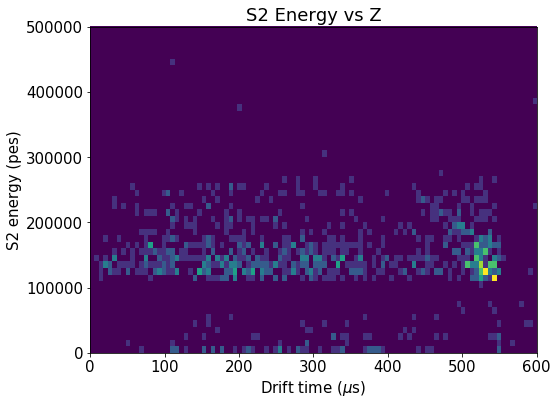

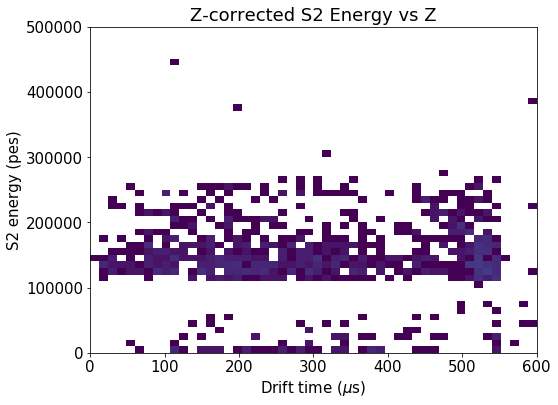

In [19]:
data = full
sel  = full.Z>0
hist2d(data.Z, data.S2e, (100, 50), range=(Zrange, [0,5e5]))
x, y, u_y = fitf.profileX(data.Z[sel], data.S2e[sel], 25, xrange=(50,550), yrange=[0,12e3])


labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 Energy vs Z")
save("S2energyvsZ_fiducial")

data = full
hist2d(data.Z, data.S2e, (50, 50), range=(Zrange, [0,5e5]), norm=colors.LogNorm(vmin=1, vmax=5e5))
x, y, u_y = fitf.profileX(data.Z[sel], data.S2e[sel], 25, xrange=(50,550), yrange=[0,12e3])


labels("Drift time ($\mu$s)", "S2 energy (pes)", "Z-corrected S2 Energy vs Z")
save("S2energyvsZ_fiducial")

# Lifetime calculation

In [20]:
fid = full
fid = fid[(fid.R < 100)] # Fiducialize in order to reduce geometrical effects
print("Ratio:", len(fid)/len(full))
fid.head()

Ratio: 0.36251402918069586


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
1,2,1.499707e+09,0,1,200.0,53.646015,278.180765,466850.0,36.867000,9599.762695,...,674237.5,36,207.3875,207.3875,25.219295,-63.289933,68.129498,-1.191607,11.817029,13.409226
4,7,1.499707e+09,0,1,200.0,39.639145,202.842133,137925.0,41.932063,11303.938477,...,657787.5,37,519.8625,519.8625,70.849812,37.603790,80.210603,0.487947,13.066028,13.746847
8,174,1.499707e+09,0,1,150.0,19.438322,96.092081,488350.0,18.971750,22185.626953,...,655062.5,43,166.7125,166.7125,22.835631,-96.191769,98.865173,-1.337714,11.996332,11.736926
9,174,1.499707e+09,1,1,150.0,19.438322,96.092081,488350.0,8.601250,1026.954712,...,1039587.5,3,551.2375,551.2375,85.160796,-15.000000,86.471736,-0.174349,7.087712,0.000000
12,178,1.499707e+09,0,1,225.0,51.012817,282.656960,302525.0,87.045937,9352.537109,...,657187.5,52,354.6625,354.6625,87.762836,35.148175,94.539460,0.380929,55.129275,96.599276


# S2 energy fiducialized

Energy at z=0 = 9000.0 +- inf
Lifetime      = 981.0 +- inf
Chi2          = 36.28          


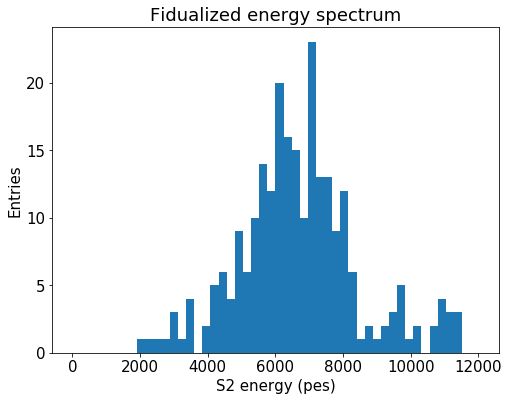

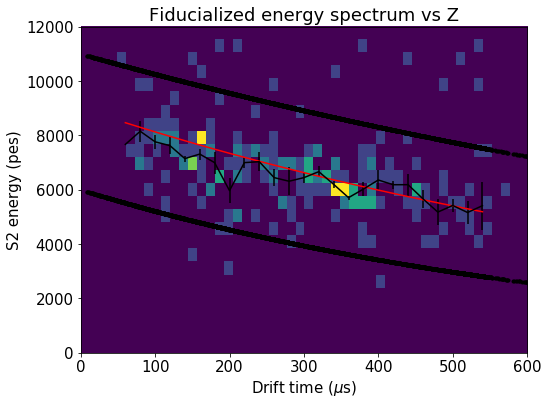

In [83]:
data = full
hist(data.S2e, 50, range=[0,12e3])
labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")
save("S2energy_fiducial")

low_cut   =  6000 * np.exp(-0.0014*data.Z.values)
high_cut  = 11000 * np.exp(-0.0007*data.Z.values)
sel       = coref.in_range(data.S2e.values, low_cut, high_cut) # remove low and high E background

hist2d(data.Z, data.S2e, (50, 25), range=(Zrange, [0,12e3]))
x, y, u_y = fitf.profileX(data.Z[sel], data.S2e[sel], 25, xrange=(50,550), yrange=[0,12e3])

plt.errorbar(x, y, yerr=u_y, fmt='k')#, profOpt)
plt.plot(data.Z.values,  low_cut, "k.")
plt.plot(data.Z.values, high_cut, "k.")

seed = 9000,-981#np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
f    = fitf.fit(fitf.expo, x, y, seed, fit_range=(50,500), sigma=u_y)

plt.plot(x, f.fn(x), fitOpt)
print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
print("Chi2          = {:.2f}          ".format(f.chi2))

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("S2energyvsZ_fiducial")

Zcorr = corrf.LifetimeCorrection(1100, 0)

# Correction by attachment

[  1.26150725e+02   9.47227851e+03   5.00000437e+01   1.00000000e+02
   1.10000000e+04   7.00000000e+02   7.51665993e-42]
[  1.50303264e+04   5.13729356e+04   1.27214171e+04   3.39135082e+02
   2.41461809e+03   1.79604856e+03   1.85688447e-02]


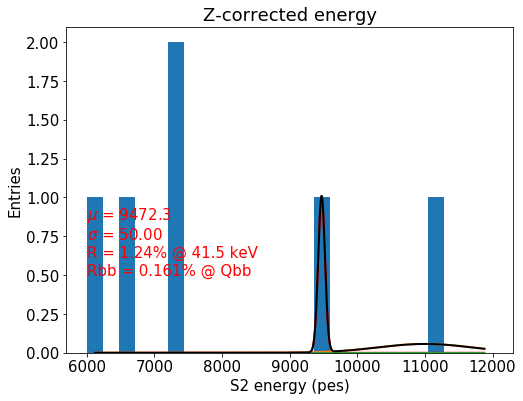

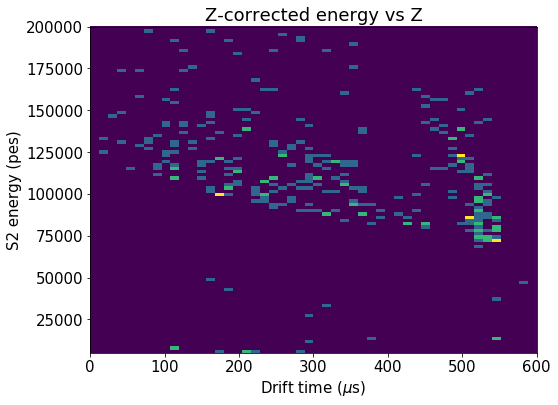

In [24]:
Efid_zcorr = fid.S2e.values * Zcorr(fid.Z.values).value

y, x, _ = hist(Efid_zcorr, 25, range=Erange_XR)

seed = 1e4,  9000, 300, 1e3, 10500, 500, 10
low  =  10,  6000,  50, 1e2,  9000,  50, 0 
upp  = 1e8, 10000, 900, 1e4, 11000, 700, 100
f    = fitf.fit(two_gauss, x, y, seed, fit_range=(8e3,11e3), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(Erange_zcorr[0]+1e3, 1*max(y)/4, gausstext(f.values, 41.5), color=fitOpt)

labels("S2 energy (pes)", "Entries", "Z-corrected energy")
save("S2energyCorr_fiducial")

hist2d(fid.Z.values, Efid_zcorr, (50, 100), range=(Zrange, Erange_zcorr))
labels("Drift time ($\mu$s)", "S2 energy (pes)", "Z-corrected energy vs Z")
save("S2energyCorrvsZ_fiducial")

(array([  9.,  17.,  19.,  34.,  48.,  25.,  49.,  47.,  47.,  42.,  37.,
         37.,  45.,  35.,  35.,  28.,  17.,  15.,  31.,  30.,  41.,  83.,
         84.,   2.,   6.]),
 array([  12.,   36.,   60.,   84.,  108.,  132.,  156.,  180.,  204.,
         228.,  252.,  276.,  300.,  324.,  348.,  372.,  396.,  420.,
         444.,  468.,  492.,  516.,  540.,  564.,  588.]),
 <a list of 25 Patch objects>)

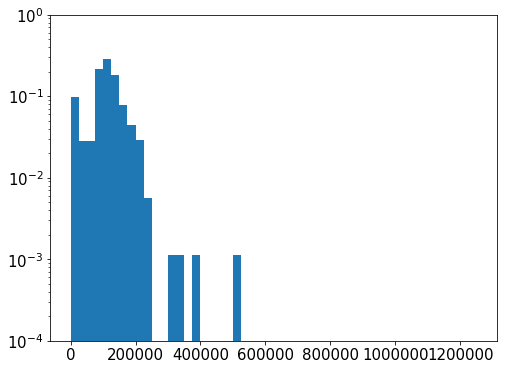

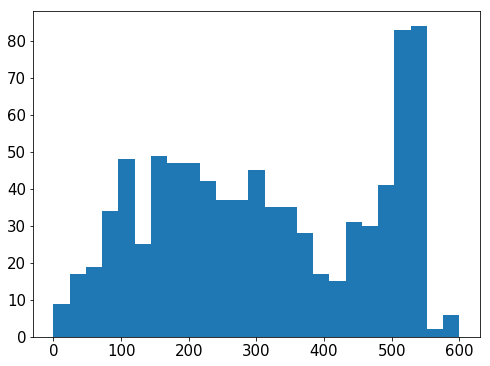

In [25]:
E_zcorr = full.S2e.values * Zcorr(full.Z.values).value

SelE = coref.in_range(E_zcorr,0e5,100e5)

y, x, _ = pdf(E_zcorr, 50, range=[0e5, 12.50e5]);


hist(full.Z[SelE],25, range=(0,600))




# Tracking

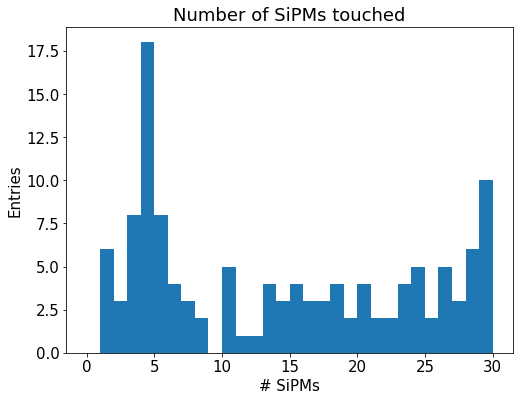

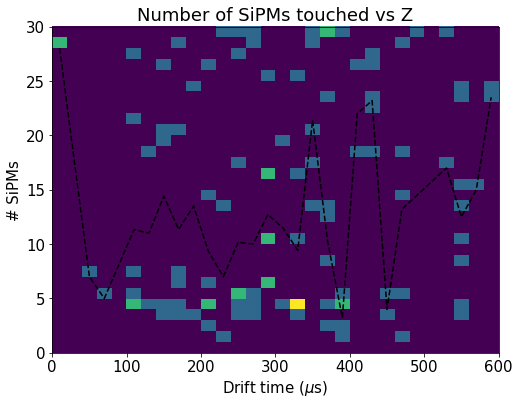

In [26]:
hist(full.Nsipm, max(NSirange), NSirange)
labels("# SiPMs", "Entries", "Number of SiPMs touched")
save("Nsipm")

hist2d(full.Z, full.Nsipm, (30, max(NSirange)), range=(Zrange, NSirange))
x, y, _ = fitf.profileX(full.Z, full.Nsipm, 30, xrange=Zrange, yrange=NSirange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs", "Number of SiPMs touched vs Z")
save("NsipmvsZ")


# Cs distribution

In [80]:
E_zcorr = full.S2e.values #* Zcorr(full.Z.values).value
sel     = coref.in_range(E_zcorr, 0e5, 8e5)
sel     = np.logical_and(sel, coref.in_range(full.Z, 0     , 400   ))
#sel     = np.logical_and(sel, full.nS2==1)
#sel     = np.logical_and(sel, full.R<50)

Kr      = full   [sel]
E_zcorr = E_zcorr[sel]

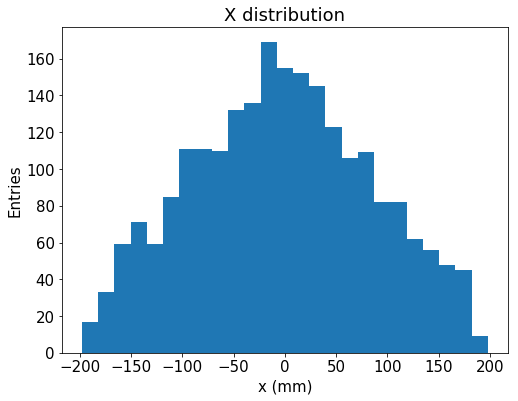

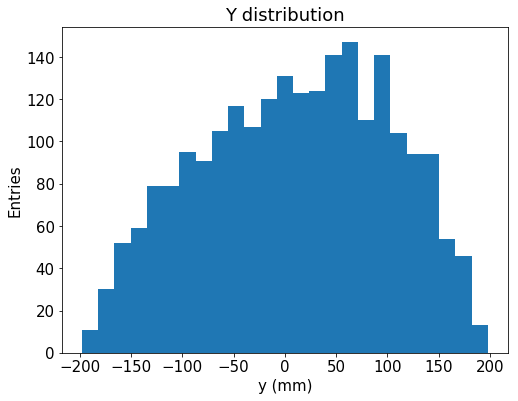

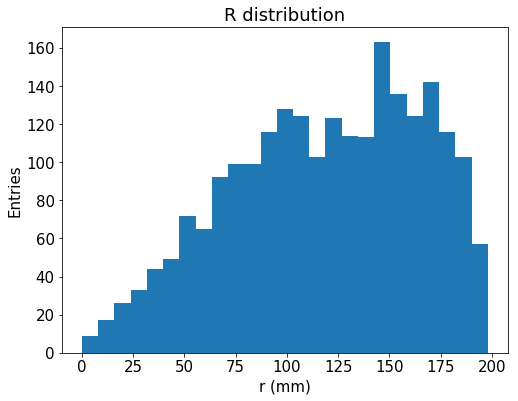

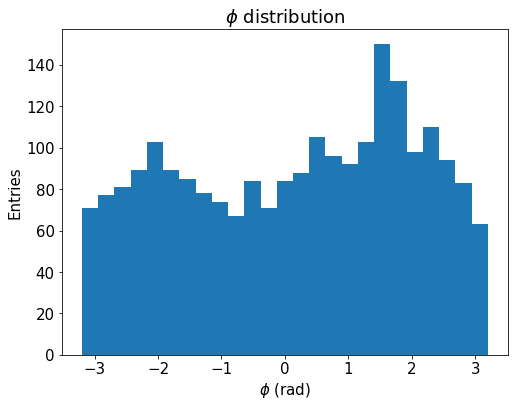

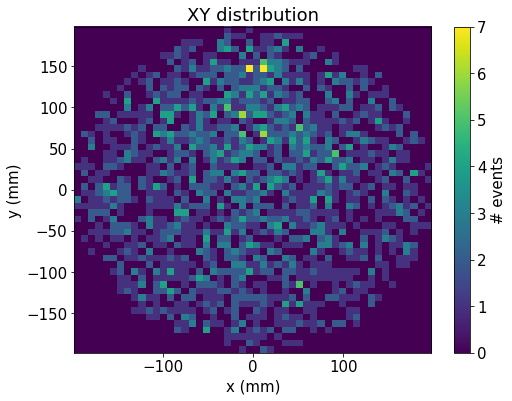

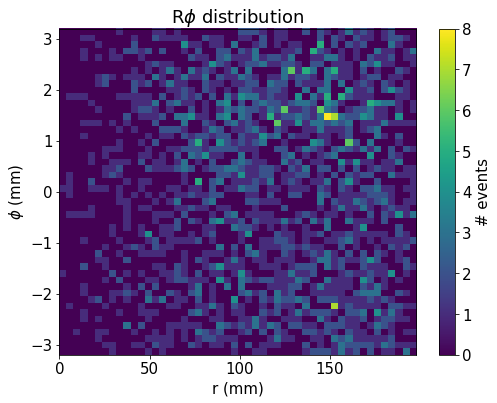

In [82]:
hist(Kr.X, 25, range=XYrange)
labels("x (mm)", "Entries", "X distribution")
save("X")

hist(Kr.Y, 25, range=XYrange)
labels("y (mm)", "Entries", "Y distribution")
save("Y")

hist(Kr.R, 25, range=Rrange)
labels("r (mm)", "Entries", "R distribution")
save("R")

hist(Kr.Phi, 25, range=Prange)
labels("$\phi$ (rad)", "Entries", "$\phi$ distribution")
save("Phi")

nXY, xs, ys, _ = \
hist2d(Kr.X, Kr.Y, (50,50), range=(XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "XY distribution")
save("XY")

hist2d(Kr.R, Kr.Phi, (nX, nY), range=(Rrange, Prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)", "R$\phi$ distribution")
save("RPhi")

# Tracking charge

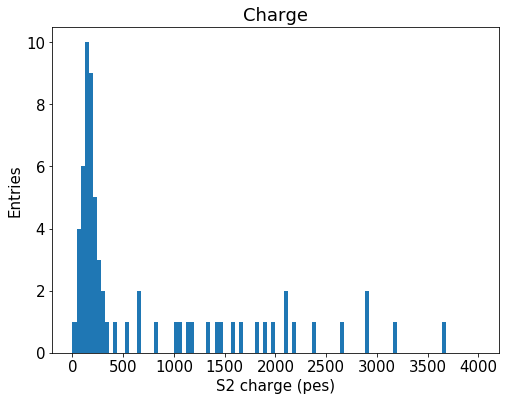

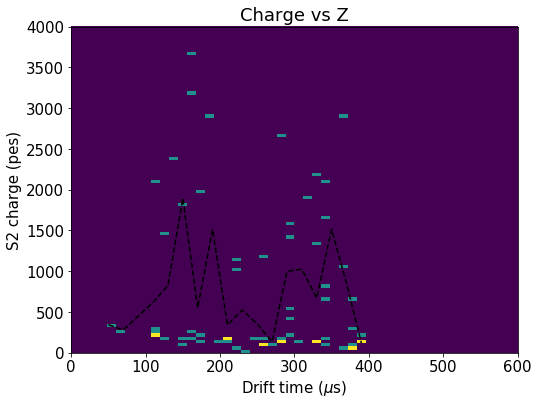

In [31]:
hist(Kr.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries", "Charge")
save("S2charge")

hist2d(Kr.Z, Kr.S2q, (50, 100), range=(Zrange, Qrange))
x, y, _ = fitf.profileX(Kr.Z, Kr.S2q, 30, xrange=Zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)", "Charge vs Z")
save("S2chargevsZ")

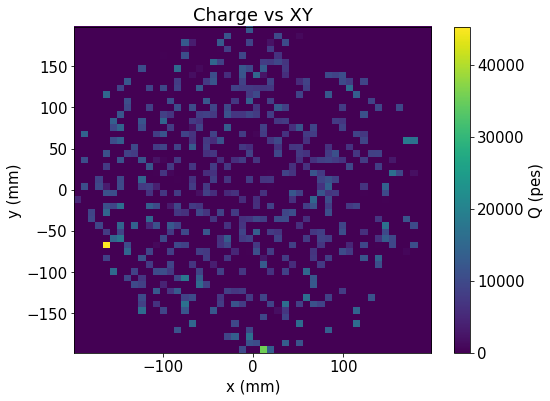

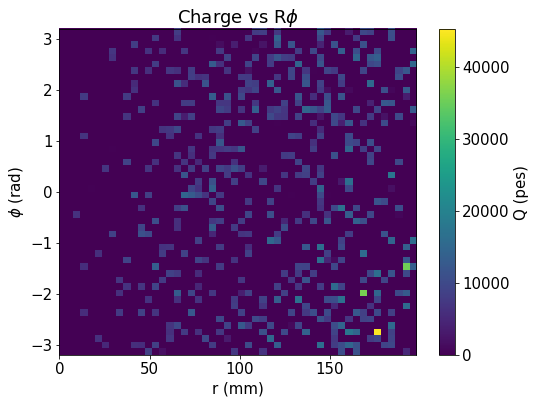

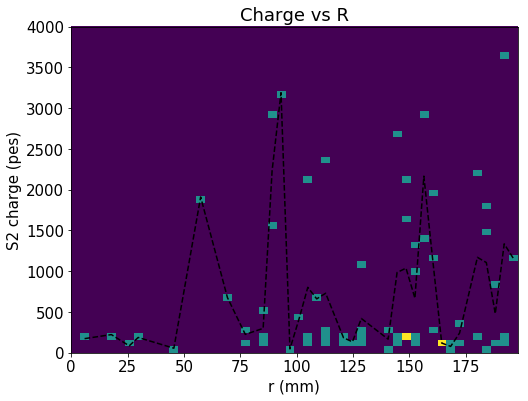

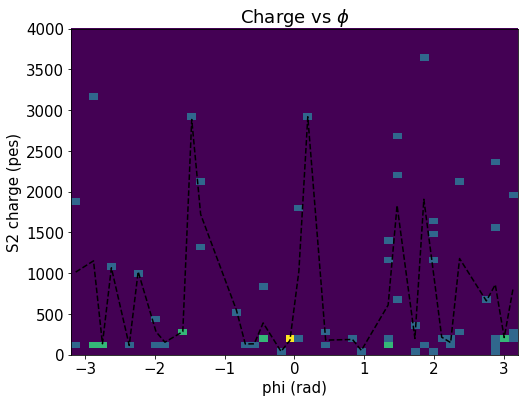

In [32]:
_, _, cb = hist2d_profile(Kr.X, Kr.Y, Kr.S2q, nX, nY, XYrange, XYrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)", "Charge vs XY")
save("QvsXY")

_, _, cb = hist2d_profile(Kr.R, Kr.Phi, full.S2q, nX, nY, Rrange, Prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)", "Charge vs R$\phi$")
save("QvsRPhi")

hist2d(Kr.R, Kr.S2q, (50, 50), (Rrange, Qrange))
x, y, _ = fitf.profileX(Kr.R, Kr.S2q, 50, xrange=Rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)", "Charge vs R")
save("QvsR")

hist2d(Kr.Phi, Kr.S2q, (50, 50), range=(Prange, Qrange))
x, y, _ = fitf.profileX(Kr.Phi, Kr.S2q, 50, xrange=Prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)", "Charge vs $\phi$")
save("QvsPhi")

# Energy vs position

In [33]:
xy_map = dstf.load_xy_corrections(corr_filename)

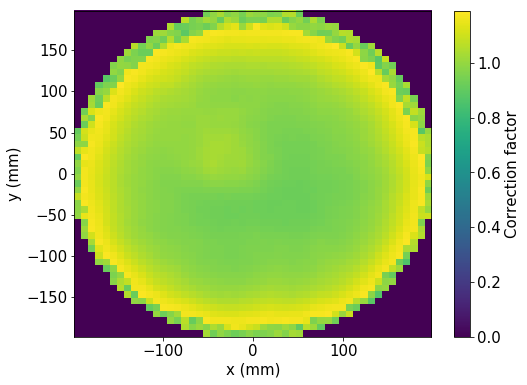

In [34]:
plot_map(xy_map)

[  4.53427467e+03   6.53235817e+03   8.99952399e+02   4.28234920e+02
   9.00000000e+03   3.55819859e+02   4.87396669e-01]
[  1.75229708e+05   3.37176056e+04   1.24635429e+04   2.05648962e+03
   9.87756939e+02   9.68146033e+02   2.71758255e-01]


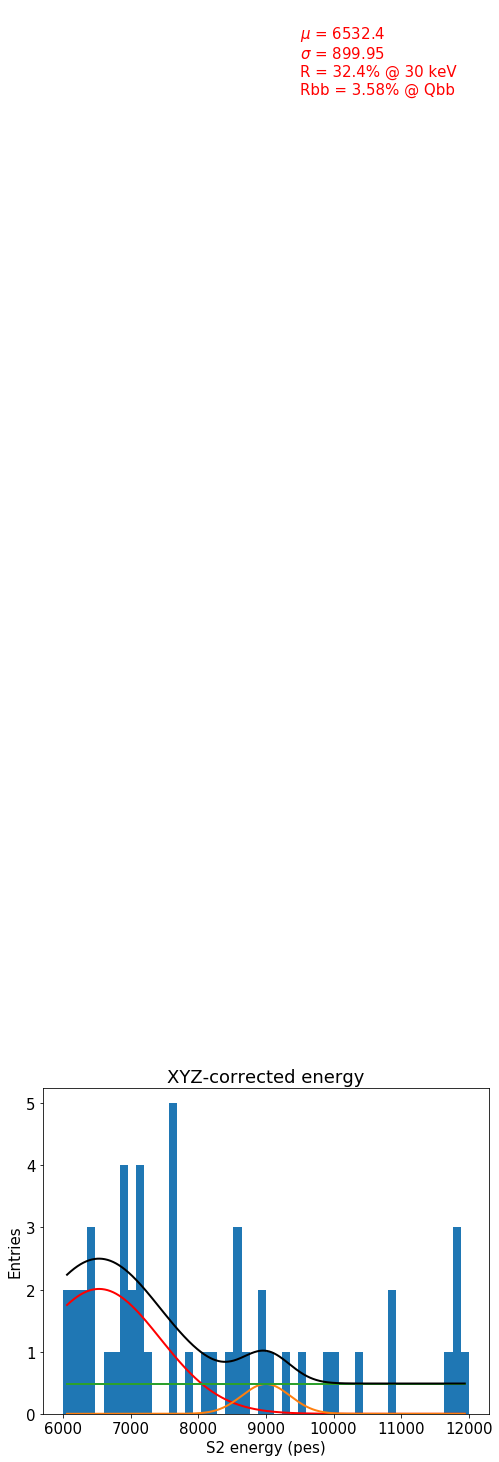

In [77]:
data = full
Efull_zcorr = data.S2e.values * Zcorr(data.Z.values).value * xy_map(data.X.values,data.Y.values).value
y, x, _ = hist(Efull_zcorr, 50, range=[6e3, 12e3])

seed = 1e4,  9000, 300, 1e3, 10000, 500, 10
low  =  10,  6000,  50, 1e2,  9000,  50, 0 
upp  = 1e8, 10000, 900, 1e5, 11000, 500, 100
f    = fitf.fit(two_gauss, x, y, seed, fit_range=(7.5e3,12e3), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(Erange_zcorr[0]+4.5e3, 1*max(y)/4+20, gausstext(f.values, 30), color=fitOpt)

labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")
save("S2energyCorr")

[  1.25300487e+02   9.07499963e+03   5.00000000e+01   1.25300487e+02
   1.04250000e+04   5.00000000e+01   9.53591524e-26]
[  4.33485569e+00   4.91533837e+00   1.70409419e+00   4.33485568e+00
   4.91533836e+00   1.70409418e+00   9.45544760e-04]


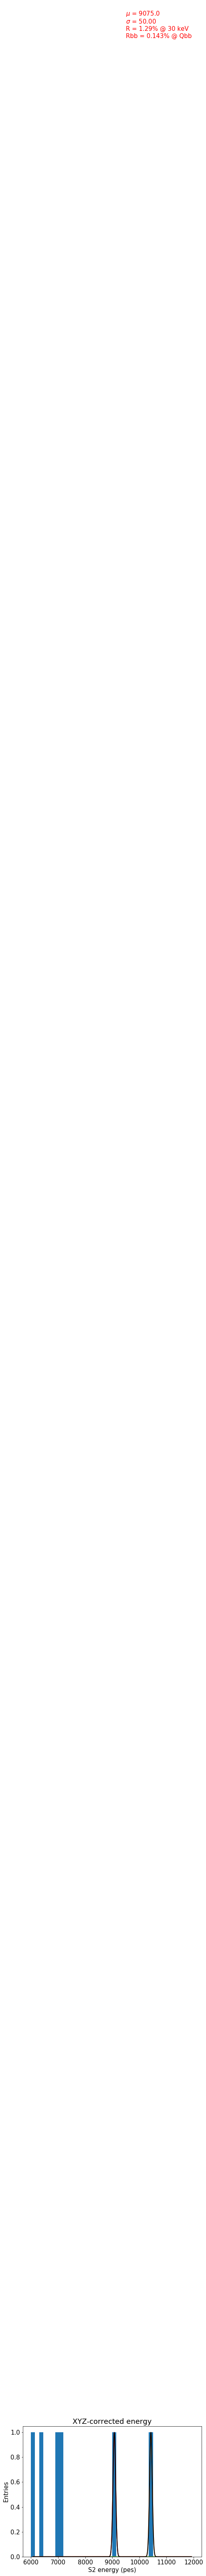

In [36]:
data = fid
Efid_zcorr = data.S2e.values * Zcorr(data.Z.values).value*xy_map(data.X.values,data.Y.values).value

y, x, _ = hist(Efid_zcorr, 40, range=[6e3, 12e3])

seed = 1e4,  9000, 300, 1e3, 10000, 500, 10
low  =  10,  6000,  50, 1e2,  9000,  50, 0 
upp  = 1e8, 10000, 900, 1e5, 11000, 500, 100
f    = fitf.fit(two_gauss, x, y, seed, fit_range=(7.5e3,12e3), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(Erange_zcorr[0]+4.5e3, 1*max(y)/4+20, gausstext(f.values, 30), color=fitOpt)

labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")
save("S2energyCorr")

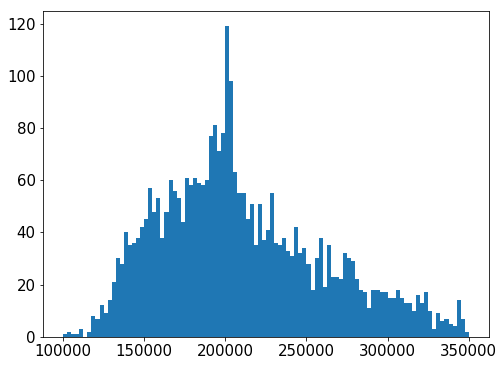

In [87]:
data = full
data = data
Efid_zcorr = data.S2e.values * Zcorr(data.Z.values).value * xy_map(data.X.values,data.Y.values).value
y, x, _ = hist(Efid_zcorr, 100, range=[1e5,3.5e5])
"""
seed =  1e4,   1.5e5, 1e3, 10
low  =  1e4,  1.45e5,  10E2, 0 
upp  =  1e8,     2e5, 5e5, 10
f    = fitf.fit(one_gauss, x, y, seed, fit_range=(1.45e5,1.75e5), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
#plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(1.25e5+1e3, 1*max(y)/3+30, gausstext(f.values, 511), color=fitOpt)

labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")
save("S2energyCorr")
""";

In [ ]:
data = fid
Efid_zcorr = data.S2e.values * Zcorr(data.Z.values).value *xy_map(data.X.values,data.Y.values).value
y, x, _ = pdf(Efid_zcorr, 50, range=[0e5,15e5])
"""
seed =  1e4,   1.5e5, 1e3, 10
low  =  1e4,  1.45e5,  10e2, 0 
upp  =  1e8,     2e5, 5e5, 10
f    = fitf.fit(one_gauss, x, y, seed, fit_range=(1.475e5,1.6e5), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
#plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(1.25e5+1e3, 1*max(y)/3+25, gausstext(f.values, 511), color=fitOpt)

labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")
save("S2energyCorr")
""";